In [1]:
from rdkit import Chem
mol = Chem.MolFromSmiles("BrCCC(CCO)CCN")
canonical_atom_order = Chem.CanonicalRankAtoms(mol)
tuple(canonical_atom_order)
(2, 5, 8, 9, 7, 4, 1, 6, 3, 0)
canonical_atom_order_inverted = tuple(zip(*sorted((j, i) for i, j in enumerate(canonical_atom_order))))[1]
canonical_atom_order_inverted
(9, 6, 0, 8, 5, 1, 7, 4, 2, 3)
canonical_mol = Chem.RenumberAtoms(mol, canonical_atom_order_inverted)
Chem.MolToSmiles(mol, canonical=True), Chem.MolToSmiles(canonical_mol, canonical=False)
('NCCC(CCO)CCBr', 'NCCC(CCO)CCBr')

('NCCC(CCO)CCBr', 'NCCC(CCO)CCBr')

In [86]:
import sys
sys.path.append('/efs-private/chemjepa/chemjepa')
from utils.tokenizer import BasicSmilesTokenizer, SmilesTokenizer
from utils.smiles import rotate_smiles, absolute_smiles

In [17]:
basictokenizer = BasicSmilesTokenizer()
tokenizer = SmilesTokenizer('vocab.txt')

In [275]:
tokenizer.vocab['*']

256

In [37]:
s = 'NCCC(CCO)CCBr'
def test_len(s):
    #s = s['0'].value
    return len(tokenizer.encode(s))-2 == len(tokenizer.tokenize(s))

In [32]:
import pandas as pd
df = pd.read_csv('pubchem-10m.txt', header = None)

In [43]:
df[0][0:10000].apply(test_len).sum()

10000

In [45]:
toks = df[0][0:10000].apply(tokenizer.encode)

In [52]:
def con(s):
    return "".join(tokenizer.convert_ids_to_tokens(s[1:-1]))

In [53]:
res = toks.apply(con)

In [58]:
print(res[res != df[0][0:10000]]) #All non reconstructed have UNK token

2026    CCC(C)C(NC(=O)C(CCCC[NH3+])NC(=O)C(CCC(=O)[O-]...
4118    CC(N)C(=O)NC(C(=O)NC(C)C(=O)OCc1ccc(OCc2ccc([U...
4521    CCC(C)C(NC(=O)CNC(=O)C(Cc1c[nH]c2ccccc12)NC(=O...
5225                                          S[I-][UNK]I
Name: 0, dtype: object


In [190]:
s = absolute_smiles("BrCCC(CCO)CCN")
s = absolute_smiles("BrCCC(***)CCN")
s = "CC(=O)NCCc1c[nH]c2ccc(OC)cc12"
sr = "CC(=*)*CCc1c[*H]c2ccc(OC)cc12"
#s = df[0][999]

r=3
mol = Chem.MolFromSmiles(s)
canonical_atom_order = Chem.CanonicalRankAtoms(mol)
print(tuple(canonical_atom_order))
s2 = rotate_smiles(s,r)
mol2 = Chem.MolFromSmiles(s2)
canonical_atom_order2 = Chem.CanonicalRankAtoms(mol2)
#print(tuple(canonical_atom_order2))
#print(s)
print(basictokenizer.tokenize(s))
#print(s2)
print(basictokenizer.tokenize(sr))
print(absolute_smiles(s))
print(len(basictokenizer.tokenize(s))==len(basictokenizer.tokenize(sr)))
#Rules
# If numbers follow atoms, also mask
# If bond precedes mask token, also mask
# If entire internal to parentheses is masked, also mask parentheses?
# If any * in a single token, mask whole token
# Adjacent atoms can be masked, atoms with same next number are adjacent

(1, 12, 2, 9, 7, 8, 14, 4, 10, 15, 5, 3, 13, 11, 0, 6, 16)
['C', 'C', '(', '=', 'O', ')', 'N', 'C', 'C', 'c', '1', 'c', '[nH]', 'c', '2', 'c', 'c', 'c', '(', 'O', 'C', ')', 'c', 'c', '1', '2']
['C', 'C', '(', '=', '*', ')', '*', 'C', 'C', 'c', '1', 'c', '[*H]', 'c', '2', 'c', 'c', 'c', '(', 'O', 'C', ')', 'c', 'c', '1', '2']
COc1ccc2[nH]cc(CCNC(C)=O)c2c1
True


In [333]:
#When you transform, a different number of tokens may be masked. 
#That's ok, but the number of tokens to predict and their positions must
#Be fed to the predictor along with the transformation

# 1.) Masker - character-wise masking
# 2.) Parser - standard parser + Mask token Fixup (Changes * to <MASK>)
# 3.) SmilesTokenizer - With Mask Tokens Pre-included
from itertools import cycle
from rdkit import Chem
import torch.nn as nn
import random
from collections import deque
import copy

class SmilesTransformations(nn.Module):
    def __init__(self,
                mask_size=4,
                **kwargs):
        super().__init__()
        self.mask_size=4
        self.init_parser = BasicSmilesTokenizer()
        
    def _set_dummy(self, atom):
        return atom.SetAtomicNum(0)
    
    def _get_n_neighbors(self, seed_atom, n):
        "Recursive connected atom search"
        neighbors = seed_atom.GetNeighbors()
        ret_n = set()
        for ne in neighbors:
            ret_n.add(ne)
            if len(ret_n) == n:
                return ret_n
        for ne in ret_n:
            ret_n = ret_n.union(self._get_n_neighbors(ne, n=n-len(ret_n)))
            if len(ret_n) == n:
                return ret_n
    
    def mask(self, smiles, seed=-1):
        mol = Chem.MolFromSmiles(smiles)
        if seed < 0:
            seed = random.randint(0,len(mol.GetAtoms()))
        #Tag atoms and then rotate instead of set up dummy?
        assert seed <= len(mol.GetAtoms())
        seed_atom = tuple(mol.GetAtoms())[seed]
        atoms_to_mask = self._get_n_neighbors(seed_atom, self.mask_size)
        atom_ns = {atom.GetIdx() for atom in atoms_to_mask}
        for atom in mol.GetAtoms():
            if atom.GetIdx() in atom_ns:
                atom.SetAtomicNum(0)
        return Chem.MolToSmiles(mol,canonical=False)#.replace(':','')
    
    def process(self, smiles):
        """
        N.B. We use * token here to additionally mask non-atom tokens
        The output is no longer a valid SMILES string and so no-longer
        Cleanly Rotatable.
        """
        parsed = self.init_parser.tokenize(smiles.replace(':',''))
        parsed = ['*' if '*' in x else x for x in parsed]
        for i,j in zip(range(0,len(parsed)-1), range(1,len(parsed))):
            if parsed[i] == '=' and parsed[j] == '*':
                parsed[i] = '*'
            elif parsed[i] == '*' and parsed[j].isnumeric():
                parsed[j] = '*'
        parsed = self._check_parentheses(parsed)
        return "".join(parsed)
    
    def _check_parentheses(self, parsed):
        for i in range(len(parsed)):
            if parsed[i] == '(':
                for j in range(i+1,len(parsed)):
                    if parsed[j] == ')':
                        parsed[i]='*'
                        parsed[j]='*'
                        break
                    elif parsed[j] != '*':
                        break
        return parsed
    
    def rotate_smiles(self, smiles, num): 
        """Perform a rotation of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        try:
            ans = deque(list(range(m.GetNumAtoms())))
        except:
            print(f"Warning, could not rotate {smiles}")
            return None
        ans.rotate(num)
        nm = Chem.RenumberAtoms(Chem.Mol(m),ans)
        return Chem.MolToSmiles(nm, canonical=False)#, canonical=canonical, isomericSmiles=isomericSmiles)

    
    def forward(self, smiles, rot, rot_init=0):
        assert isinstance(smiles, str)
        assert isinstance(rot, int)
        if rot_init > 0:
            smiles = self.rotate_smiles(smiles, rot_init)
        masked_smiles = self.mask(smiles)
        rotated_smiles = self.rotate_smiles(masked_smiles, rot)
        #masked_smiles, rotated_smiles = Chem.MolToSmiles(masked_mol), Chem.MolToSmiles(rotated_mol)
        return self.process(masked_smiles), self.process(rotated_smiles)
        
                

In [334]:
masker=  SmilesTransformations()
#print(masker.check_parentheses('CC(***)CC'))
for i in range(17):
    print(masker(s2, i, i))#, i))
#Chem.MolToSmiles(mol)

('COc1cc2*(CCNC(C)=O)****cc1', 'COc1cc2*(CCNC(C)=O)****cc1')
('c1c(OC)cc2*(***C(C)=O)c[nH]c2c1', 'c1cc(OC)cc2*(***C(C)=O)c[nH]c12')
('c1c*(OC)****(CCNC(C)=O)c[nH]c12', '[nH]1c2cc*(OC)****(CCNC(C)=O)c1')
('c12ccc(OC)cc1c(CC*******)c[nH]2', '***(*CCc1c[nH]c2ccc(OC)cc21)*')
('[nH]1c2ccc(OC)c***(*CNC(C)=O)**', 'C(C)(=O)NC****[nH]c2ccc(OC)c***')
('c1[nH]c2ccc(OC)cc2c1CC*******', 'C(*******)Cc1c[nH]c2ccc(OC)cc21')
('***(*CCc1c[nH]c2ccc(OC)cc12)*', 'c1(OC)cc2c(CC*******)c[nH]c2cc1')
('*******CCc1c[nH]c2ccc(OC)cc12', 'c1cc(OC)cc2c(CC*******)c[nH]c12')
('C(C)(=O)NCC**c***ccc(OC)*c12', '*****C*(CCNC(C)=O)C1*=C(OC)C=C2')
('*(******)CCc1c[nH]c2ccc(OC)cc12', '[nH]1c2ccc(OC)cc2c(CC*******)c1')
('C(NC(C)=O)Cc1c[nH]c2cc*****cc12', 'c1[nH]c2cc*****cc2c1CCNC(C)=O')
('C(CNC(C)=O)******ccc(OC)cc12', '**(CCNC(C)=O)****ccc(OC)cc12')
('**(***C(C)=O)c[nH]c2ccc(OC)cc12', 'CC(=O)*****c[nH]c2ccc(OC)cc21')
('****(*CNC(C)=O)*[nH]c1ccc(OC)c2', 'N(C(C)=O)C****[nH]c2ccc(OC)c***')
('c1c2c(CCNC(C)=O)c[nH]c2cc****', 'C(

In [238]:
from itertools import cycle

li = [0, 1, 2, 3]

running = True
licycle = cycle(li)
# Prime the pump
nextelem = next(licycle)
for i in range(len(li)-1):
    thiselem, nextelem = nextelem, next(licycle)
    nextelem=99
print(li)

[0, 1, 2, 3]


COc1ccc2[nH]cc(CCNC(C)=O)c2c1


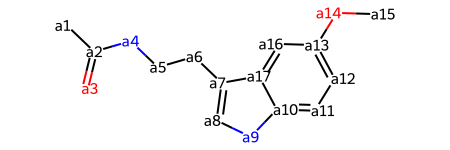

In [134]:
# Iterate over the atoms
print(Chem.MolToSmiles(mol))
for i, atom in enumerate(mol.GetAtoms()):
    # For each atom, set the property "atomLabel" to a custom value, let's say a1, a2, a3,...
    atom.SetProp("atomLabel", f"a{i+1}")

mol

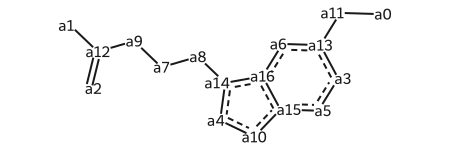

In [189]:
# Iterate over the atoms
for i, atom in enumerate(mol.GetAtoms()):
    # For each atom, set the property "atomLabel" to a custom value, let's say a1, a2, a3,...
    atom.SetProp("atomLabel", f"a{canonical_atom_order[i]}")
mol

(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac46d0>,)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac4900>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac4040>)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac46d0>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac4040>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac47b0>)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac4900>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac4040>)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac46d0>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac4040>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac47b0>)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac4900>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac4040>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac47b0>)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac46d0>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac4040>)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac4900>, <rdkit.Chem.rdchem.Atom object at 0x7f6744ac4040>)
(<rdkit.Chem.rdchem.Atom object at 0x7f6744ac46d0>, <rdkit.Chem.rdchem.At

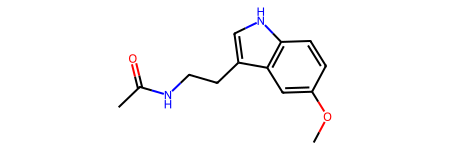

In [137]:
# Iterate over the atoms
for i, atom in enumerate(mol2.GetAtoms()):
    # For each atom, set the property "atomLabel" to a custom value, let's say a1, a2, a3,...
    #atom.SetProp("atomLabel", f"a{canonical_atom_order2[i]}")
    print(atom.GetNeighbors())

mol2

In [125]:
m = Chem.MolFromSmiles('C1OC1')
for atom in m.GetAtoms():
  atom.SetAtomicNum(0)
  print(atom.GetAtomicNum())
print(Chem.MolToSmiles(m))

0
0
0
*1**1


In [ ]:
#If the connecting number is masked, mask the connecting number